### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [52]:
# #
# import sys
# #
# from google.colab import drive
# #
# drive.mount('/content/drive')
# #
# sys.path.append('/content/drive/MyDrive/IntProject')

In [53]:

import sys

# del sys.modules['data_func']
del sys.modules['utils']
# del sys.modules['model']


In [54]:
# pip install yeoda

In [55]:
# pip install tifftools

In [56]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
import pandas as pd
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A
import warnings
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nadia/PycharmProjects/InterdisciplinaryProject/utils.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [57]:
# pip install tqdm

In [58]:
# pip install torchvision


### Data Preparation & Augmentation

In [59]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [60]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),

], )
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ], )


In [61]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask',
                           './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                            './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results1.txt'
    model_file = './drive/MyDrive/IntProject/model1.pt'
else:
    train_set = ImageDataset('./train/', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val/', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results1.txt'
    model_file = './model1.pt'


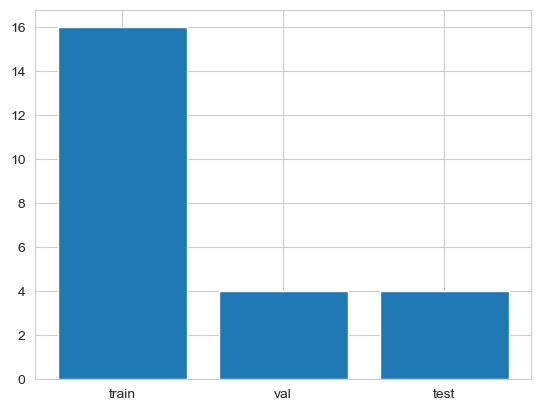

In [36]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

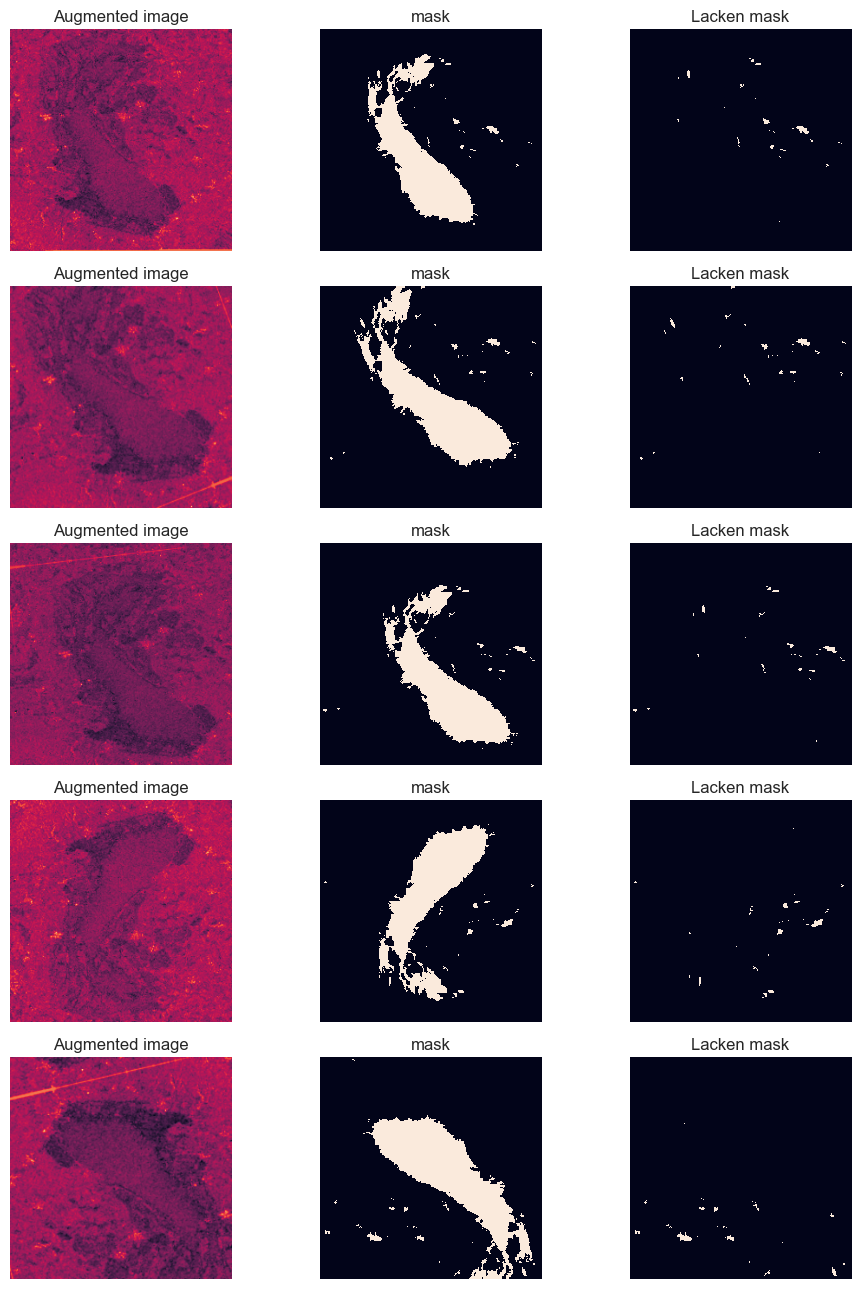

In [19]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [20]:
epochs = 50
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
global_step = 0

In [ ]:
train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
               model_file, best_dice=0, patience=10)

In [21]:
columns = [
    'epoch', 'train loss', 'valid loss', 'train_dice', 'train_l_dice', 'train_bal_acc',
    'train_l_bal_acc', 'val_dice', 'val_l_dice', 'val_l_bal_acc', 'val_bal_acc'
]

data = pd.read_csv(dict_file, names=columns)
data.head(5)

,epoch,train loss,valid loss,train_dice,train_l_dice,train_bal_acc,train_l_bal_acc,val_dice,val_l_dice,val_l_bal_acc,val_bal_acc
0,0,1.277909,2.042178,tensor(0.3818),tensor(0.0118),0.724682,0.585392,tensor(0.2329),tensor(0.0048),0.500011,0.500010
1,1,1.065139,5.142638,tensor(0.5468),tensor(0.0242),0.821327,0.575830,tensor(0.2379),tensor(0.0047),0.500000,0.500000
2,2,0.977837,6.325280,tensor(0.5798),tensor(0.0472),0.836949,0.614499,tensor(0.2430),tensor(0.0058),0.500024,0.500021
3,3,0.951487,7.077151,tensor(0.6289),tensor(0.0514),0.820469,0.589035,tensor(0.2236),tensor(0.0046),0.500146,0.500128
4,4,0.920920,4.290287,tensor(0.6086),tensor(0.0482),0.833651,0.596712,tensor(0.2633),tensor(0.0057),0.577137,0.559143


In [22]:

data['val_dice'] = data['val_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
data['train_dice'] = data['train_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
data['val_l_dice'] = data['val_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
data['train_l_dice'] = data['train_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)

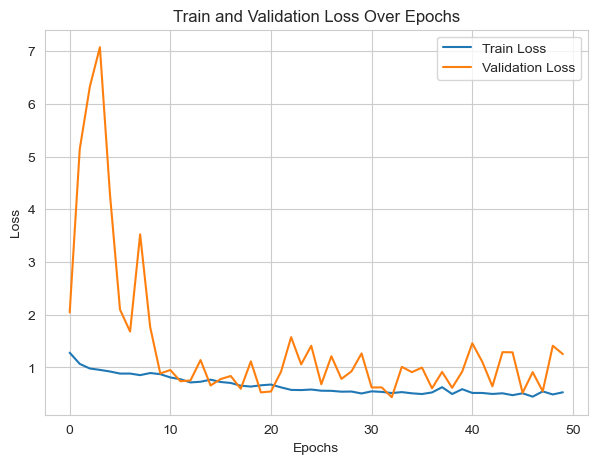

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train loss'], label='Train Loss')
plt.plot(data.index, data['valid loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


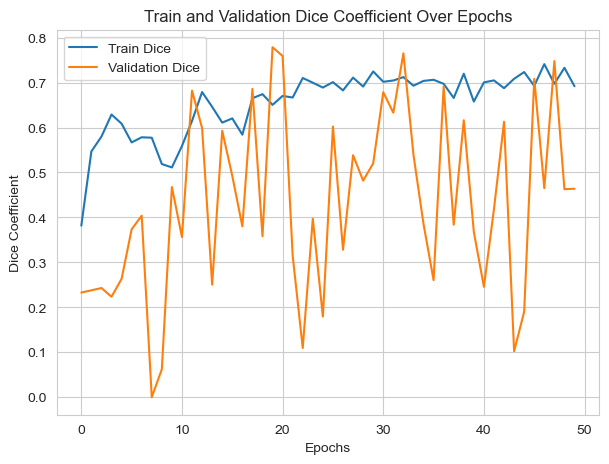

In [24]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_dice'], label='Train Dice')
plt.plot(data.index, data['val_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs')
plt.legend()
plt.show()


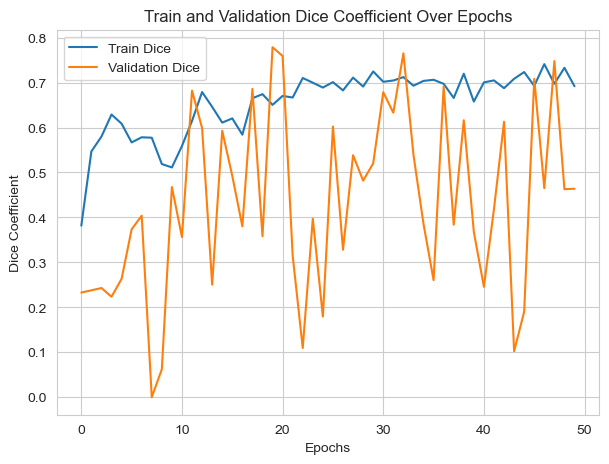

In [25]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_dice'], label='Train Dice')
plt.plot(data.index, data['val_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs')
plt.legend()
plt.show()


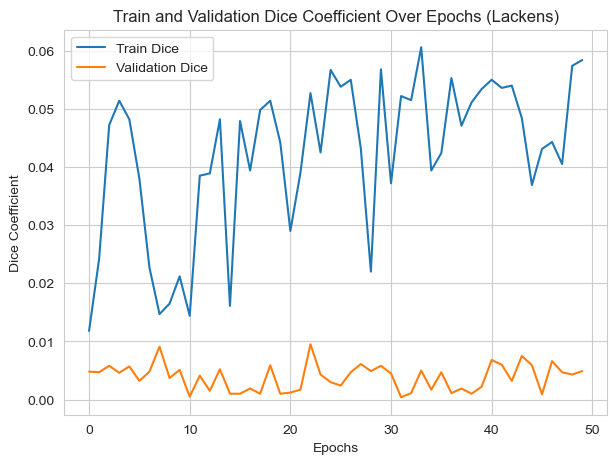

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_l_dice'], label='Train Dice')
plt.plot(data.index, data['val_l_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs (Lackens)')
plt.legend()
plt.show()


#### Evaluating on Test Data

In [62]:
model = UNet(1, 1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_4171/2905527223.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_file)  # Load th

Dice Coefficient: 0.8487908840179443
Dice Coefficient Lackens: 0.002943316474556923
IoU: 0.7432303428649902
IoU Lackens: 0.0017154966481029987
Accuracy: 0.9063389301300049
Accuracy Lackens: 0.4872400462627411


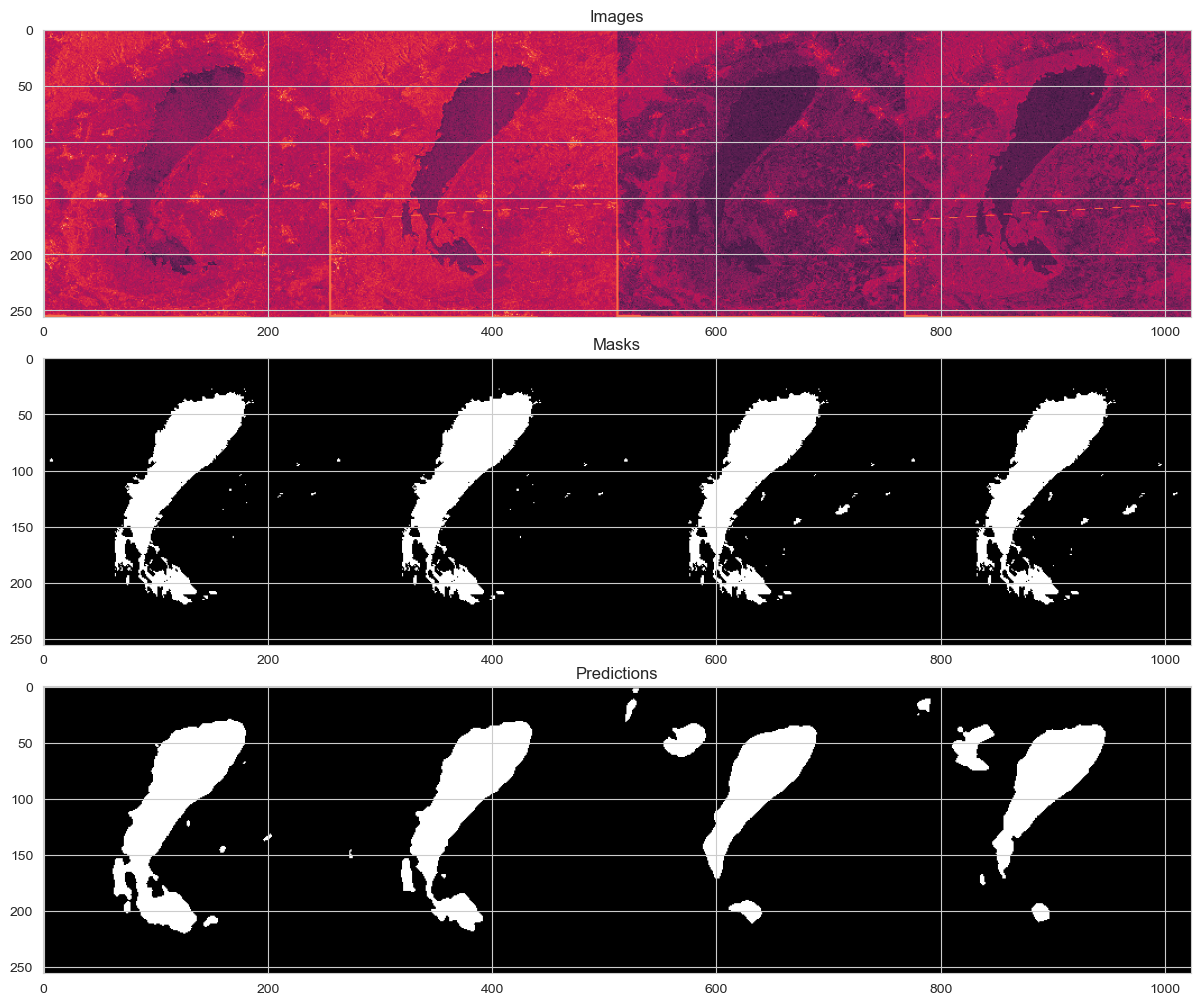

In [63]:
model.eval()
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)